In [128]:
import kmeans_qaoa as kq
from qiskit import IBMQ
import numpy as np
import coreset
import networkx as nx
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit import execute, QuantumCircuit
from qiskit.tools.monitor import job_monitor
import pickle

In [129]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-04-30 11:45:40,366: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')

In [130]:
backends = provider.backends()
for b in backends: print(b)

ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_london
ibmq_burlington
ibmq_essex
ibmq_armonk
ibmq_rome


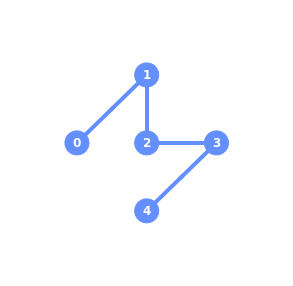

In [131]:
shots = 8192
P = 1
qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
device = provider.get_backend('ibmq_rome')
noise_model = NoiseModel.from_backend(device)
basis_gates = device.configuration().basis_gates
coupling_map= device.configuration().coupling_map
props = device.properties()
plot_gate_map(device)

In [132]:
coreset_vectors = np.load('epilepsy_coreset_vectors.npy')
coreset_weights = np.load('epilepsy_coreset_weights.npy')
for v, w in zip(coreset_vectors, coreset_weights):
    print(v,w)

[ 2.78581391e+02  3.35911565e+02  3.96187130e+02  4.25143043e+02
  4.09009739e+02  3.61003478e+02  3.18502087e+02  2.96687130e+02
  3.13558000e+02  3.79168435e+02  4.52827478e+02  4.58042174e+02
  3.85687304e+02  1.40088870e+02 -2.34788783e+02 -8.17911739e+02
 -1.34919330e+03 -1.42025530e+03 -1.13451522e+03 -5.63551565e+02
 -1.17644609e+02  1.14543130e+02  2.62884348e+02  3.52883217e+02
  3.70118870e+02  3.40159130e+02  2.65785652e+02  1.84874783e+02
  1.06393565e+02  6.69354783e+01  3.13499130e+01  2.42125217e+01
  3.38598261e+01  6.32998261e+01  1.03955652e+02  1.39278087e+02
  1.66162261e+02  1.82316609e+02  1.82998522e+02  1.78818870e+02
  1.71964087e+02  1.63773826e+02  1.43700783e+02  9.91438261e+01
  1.45460870e+01 -8.54680000e+01 -1.84329565e+02 -2.35297652e+02
 -1.95105304e+02 -1.03918609e+02  8.81817391e+00  1.02693913e+02
  1.50210783e+02  1.74653391e+02  1.81183130e+02  1.75978174e+02
  1.50606696e+02  8.99990435e+01 -4.02173913e-01 -1.05971565e+02
 -2.20633478e+02 -2.91077

The corresponding problem Hamiltonian is:
H = 1.2e+12ZZIII + 2.4e+11ZIZII + 4.7e+12ZIIZI + 2.1e+12ZIIIZ + -2.3e+13IZZII + 8.1e+11IZIZI + 8.2e+11IZIIZ + 8.1e+12IIZZI + -7.5e+12IIZIZ + -2.8e+12IIIZZ 


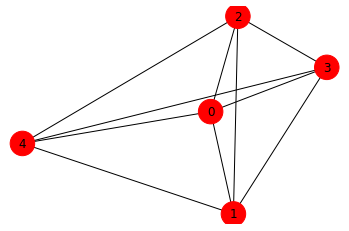

In [153]:
coreset_temp = [(w, v) for w, v in zip(coreset_weights, coreset_vectors)]
coreset_points, G, H = kq.gen_coreset_graph(coreset=coreset_temp, metric='dot')
kq.plot_coreset_graph(coreset_points, G, twoD=False)
hstr = ''
for term in H:
    hstr += '{:.1e}{} + '.format(term[0], ''.join(term[1]))
hstr = hstr[:-2]
print('The corresponding problem Hamiltonian is:\nH = {}'.format(hstr))

In [154]:
num_params = 2
init_params = None
#init_params = [1.80443779 1.03219131]
opt_params, opt_cost = kq.optimize_qaoa(init_params, num_params, shots, P, G, coupling_map, device=device)

Current iteration: 0, Num function calls: 3, best so far: -15787380199962.5019531            
Current iteration: 1, Num function calls: 7, best so far: -15787380199962.5019531            
Current iteration: 2, Num function calls: 9, best so far: -15787380199962.5019531            
Current iteration: 3, Num function calls: 10, best so far: -15787380199962.5019531            
Current iteration: 4, Num function calls: 14, best so far: -15787380199962.5019531            
Current iteration: 5, Num function calls: 18, best so far: -15787380199962.5019531            
Current iteration: 6, Num function calls: 20, best so far: -15787380199962.5019531            
Current iteration: 7, Num function calls: 24, best so far: -15787380199962.5019531            
Current iteration: 8, Num function calls: 25, best so far: -15787380199962.5019531            
Current iteration: 9, Num function calls: 29, best so far: -15787380199962.5019531            
Current iteration: 10, Num function calls: 33, best s

In [141]:
-11057738927199.9355469 - -11583903661467.5253906

526164734267.58984

In [155]:
opt_params = [0.17552137, 1.91898255]
gamma, beta = opt_params

In [156]:
circuit, initial_layout = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G, ising=False, topology=device.configuration().coupling_map)
print(circuit.draw(output='text', fold=180))
initial_layout = [0,1,2,3,4]
print(initial_layout)
circuit_bad = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G)
print(circuit_bad.draw(output='text', fold=180))

        ┌───┐ ░                   ┌───┐                                                   ┌───┐                                                         ░ ┌───────────┐ ░ ┌─┐      »
   q_0: ┤ H ├─░───■───────────────┤ X ├──■────────────────────────────────■───────────────┤ X ├──■────────────────────────────────■─────────────────■───░─┤ Rx(3.838) ├─░─┤M├──────»
        ├───┤ ░ ┌─┴─┐┌───────────┐└─┬─┘┌─┴─┐                  ┌───┐     ┌─┴─┐┌───────────┐└─┬─┘┌─┴─┐                  ┌───┐     ┌─┴─┐┌───────────┐┌─┴─┐ ░ ├───────────┤ ░ └╥┘┌─┐   »
   q_1: ┤ H ├─░─┤ X ├┤ Rz(-pi/0) ├──■──┤ X ├──■───────────────┤ X ├──■──┤ X ├┤ Rz(-pi/0) ├──■──┤ X ├──■───────────────┤ X ├──■──┤ X ├┤ Rz(-pi/0) ├┤ X ├─░─┤ Rx(3.838) ├─░──╫─┤M├───»
        ├───┤ ░ └───┘└───────────┘┌───┐└───┘┌─┴─┐┌───────────┐└─┬─┘┌─┴─┐└───┘└───────────┘┌───┐└───┘┌─┴─┐┌───────────┐└─┬─┘┌─┴─┐└───┘└───────────┘└───┘ ░ ├───────────┤ ░  ║ └╥┘┌─┐»
   q_2: ┤ H ├─░───■───────────────┤ X ├──■──┤ X ├┤ Rz(-pi/0) ├──■──┤ X ├──■───────────────┤ X ├

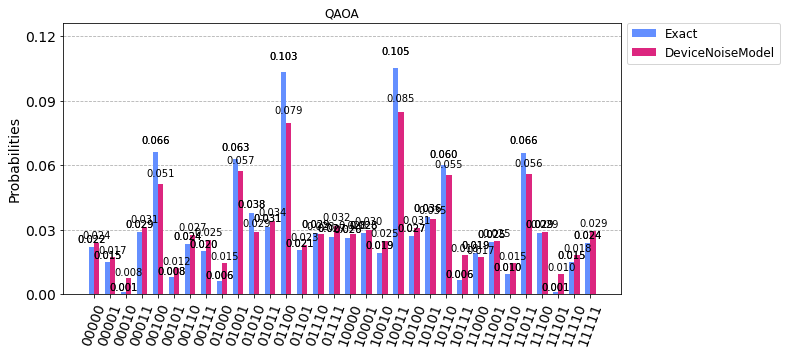

In [157]:
noisy_result = execute(circuit, qasm_simulator, basis_gates=basis_gates, shots=shots, noise_model=noise_model,
                      coupling_map=coupling_map, backend_properties=props, initial_layout=initial_layout).result()
noiseless_results = execute(circuit, qasm_simulator, shots=shots).result()

noisy_counts = kq.reorder_bitstrings(P, len(G.nodes), noisy_result.get_counts())
noiseless_counts = kq.reorder_bitstrings(P, len(G.nodes), noiseless_results.get_counts())
plot_histogram([noiseless_counts, noisy_counts], figsize=(10,5), legend=['Exact', 'DeviceNoiseModel'], title='QAOA')

In [160]:
qpu_job = execute(circuit, backend=device, shots=shots, initial_layout=initial_layout)
job_monitor(qpu_job)
qpu_counts = kq.reorder_bitstrings(P, len(G.nodes), qpu_job.result().get_counts())

Job Status: job has successfully run


In [161]:
qpu_job_bad = execute(circuit_bad, backend=device, shots=shots, initial_layout=initial_layout)
job_monitor(qpu_job_bad)
qpu_bad_counts = qpu_job_bad.result().get_counts()

Job Status: job has successfully run


In [168]:
plot_histogram([noiseless_counts, qpu_counts, qpu_bad_counts], figsize=(12, 5), legend=['NoiselessSim', 'ibmq_rome (w/ network)', 'ibmq_rome (w/o network)'], bar_labels=False, title='k-means QAOA on Epilepsy m=5 coreset')
fig = plot_histogram([noiseless_counts, qpu_counts, qpu_bad_counts], figsize=(12, 5), legend=['NoiselessSim', 'ibmq_rome (w/ network)', 'ibmq_rome (w/o network)'], bar_labels=False, title='k-means QAOA on Epilepsy m=5 coreset')
fig.set_tight_layout(True)
fig.savefig('kmeans_epilepsy_results.pdf')

In [163]:
partition = '01100'
cluster_centers = kq.compute_centroids(partition, coreset_points)
new_centers = []
for cntr in cluster_centers:
    new_centers.append(np.append(cntr, [0]))
print(new_centers)

mu_plus: [ 16.88752806  20.18266343  31.03901036  35.69886918  40.45708836
  40.84969482  40.57994403  40.25764372  37.57710673  34.49828333
  29.09857647  26.1607329   21.31320713  16.17805338  18.14786199
  20.61135056  25.16255853  19.34688664  13.70279385   4.37605517
  -9.29777003 -14.15409365 -18.70439979 -13.29197532 -12.4258153
   0.76698479  13.4228817   19.03404351  29.59688888  40.29134114
  50.44476023  55.6621735   64.69365759  67.51783733  69.81885885
  66.52547337  58.77913944  48.41145589  36.94082971  34.40637296
  28.68944199  23.40539224  11.7165285    5.40590008  -0.71387042
   3.01102693   4.39578982   9.55086691  10.88106638  11.06776203
  12.71075576   1.43395566  -5.06386236 -12.03480857 -18.05647599
 -30.56651095 -38.47470818 -48.22021199 -53.75928102 -53.82132853
 -48.22222588 -40.5433227  -34.03652844 -22.52274403  -7.28624067
   5.33895476  23.32469165  31.52270555  39.53053387  36.07081312
  36.07369882  27.08567909  21.08536713  15.24354328  11.48341329
  

In [159]:
data_vectors = np.load('Datasets/epilepsy_data_vectors.npy')
print('{:e}'.format(coreset.get_cost(data_vectors, cluster_centers)))

5.581233e+10


In [39]:
qaoa_results = {'noiseless':noiseless_counts, 'noisy':noisy_counts, 'rome':qpu_counts}
#pklFile = open('HardwareResults/rome_epilepsy_m5.pickle', 'wb')
#pickle.dump(qaoa_results, pklFile)
#pklFile.close()